A quick scan of the data science blogosphere turns up countless articles where people plot some variable X vs. some performance indicator Y and suggest confidently that the ideal value of X is at the peak of Y. This is the “correlation does not imply causation” mistake (two examples below, or you can check out the rest of my series here). The solution is to use proper causal inference, but the barrier is at least two-fold: education and tools.

The current state of things doesn’t lend well to scaling up causal inference. Assuming someone making these plots has some quantitative background, so knows probability theory and stats, but no background in causal inference, they would need to go through a course in causal inference (at least) to get the background to do it properly. That’s if they don’t need a course on probability, statistics, programming, etc. A minimum of a semester of graduate level education is too much to ask of an entry-level analyst if we want the growth of data departments to keep pace with the growth of organizations.

The solution, then, is not to require the educational background, but to provide reasonable safeguards with better tools to help an analyst do good causal inference. Some of these are easy to implement: automatically compute error bars, and add them to plots; raise exceptions (or at least warnings) if basic assumptions on the support of the data aren’t satisfied. These things take a little more thought at implementation time, and require integration with actual workflows to make sure they’re done well. That’s a big logistical issue, but it’s solvable.

The real hard part is around checking structural assumptions in the data. To do that well without an expert (it’s hard even with an expert!), you need observational causal graph inference, and testing around whether the variables being controlled render the desired causal effect identifiable. The controlling algorithm, then, needs an expected causal graph to check when you request causal effects. If you’re happy to accept hypothesis graphs as assumptions that precede your analysis, that can be great for rigor, but it hurts ease of use. I may add that option to the package in the near future, to automate some checks.

In short, the logic goes something like: If we want correct causal inference to be common, people need the skills to do it. If the bar is too high to make it common, we have to lower the bar. By lowering the bar, the damage done by incorrect causal inference is (hopefully!) less than that done by no attempt at causal inference.

tl;dr: I think if we can move from naive plotting of conditional expectations (controlling for the null set) to controlling for covariates larger than the null set, that represents real progress in the day-to-day use of causal inference in data science.

So now, I’d like to introduce a simple extention of the pandas DataFrame object that is made for plotting inferred causal effects, in the Pearlian sense of interventional conditional distributions (more precisely here, expectations).

The new stuff: causality.analysis.dataframe

I wanted to make a tool that works well within an analyst’s workflow, and extended some basic tools they already work with. Extending the pandas DataFrame seemed like a nice way to go. I’ve created a new CausalDataFrame object that is the same, but comes with a new CausalDataFrame.zplot method. This method is a hack that sits on top of the usual DataFrame.plot method, and overrides a few of its plot types (and creates some new ones). It should still be considered experimental, but has worked well in test cases.

I’ll do a quick demo, then get into the weeds with it. First for continuous variables. We’ll review the basic idea, then do the demo.

Suppose you’re an advertiser, and you’d like to see how the number of return visits to your site, Y, changes as you vary the number of ads users see during their sessions (on average), X, around the current value. There’s a problem, though. You can’t collect experimental data, since you have commitments to advertisers. You can only observe what usually happens. In general, there are other factors that influence the number of ads on your site as well as the number of return visits. One of them, Z1, is how popular your site is right now. If it’s more popular, more advertisers want to advertise with you, so you end up showing more ads. If it’s more popular, people tend to return more often. Then, there’s a positive relationship between showing ads, X, and visits to your site, Y, that is just due to this confounding effect! There can be other similar effects, so we’ll include another Z2 variable just for illustration.

We’d like to know what would happen if, keeping the confounding variables fixed, we vary X. The problem is that a naive plot of y vs x will include the confounding effects.

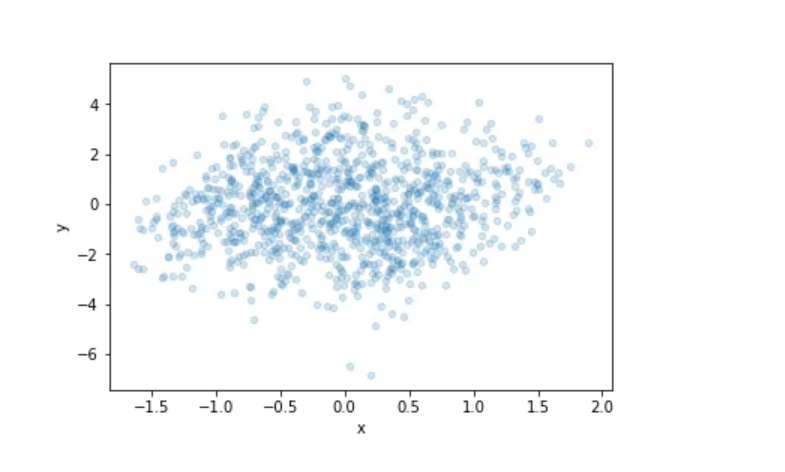

so the net effect looks like nothing, or maybe slightly positive. We’d like to control the Z effects, and we can do it with this package!

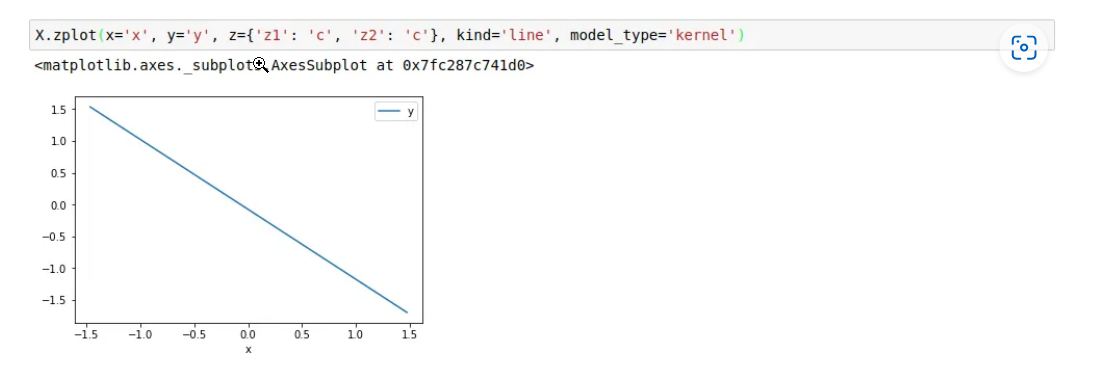

so you can recover the causal y = -x relationship between the number of ads you show, and the number of visits people make to the site! So you can try it, here is the code for this example, with a little more technical explanation:

In [1]:
%matplotlib inline

In [4]:
pip install causality

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for causality: filename=causality-0.0.10-py3-none-any.whl size=18940 sha256=3e14b6189615776e8f223dbf11a1496576ec1ad855f6568de04f8728981915d9
  Stored in directory: /root/.cache/pip/wheels/5e/4a/af/5580368b28240289c3bdf32b08d72769a8a1ebad683e500bfa
Successfully built causality


In [5]:
import numpy as np
import pandas as pd
from causality.analysis.dataframe import CausalDataFrame


In [6]:
N = 1000
lower = -1
upper = 1
z1 = np.random.uniform(lower, upper, size=N)
z2 = np.random.uniform(lower, upper, size=N)
x  = np.random.uniform(lower, upper, size=N) + (z1 + z2)/2.
z  = z1 + z2
y  = np.random.normal(size=N) - x + 2.* z
X  = CausalDataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2})

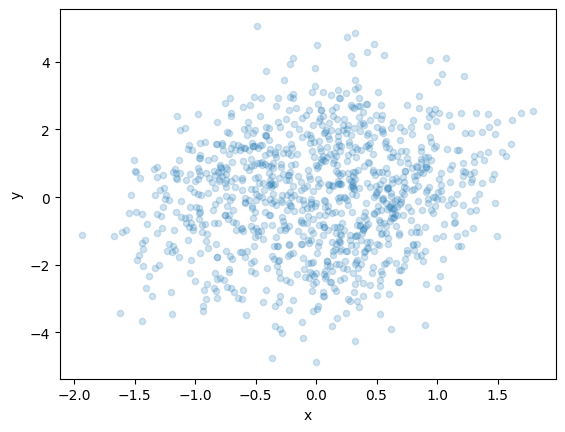

In [7]:
X.plot(x='x', y='y', style='bo', alpha=0.2, kind='scatter');

I used a local linear regression to do the controlling here. Generally, you can use whatever model you like, but they might not perform as well. Random forest and a deep feed-forward network both have some trouble at the edge of the support of the data with this example.

Next, we can do the same thing with categorical data. I did it here with a binary X variable, but the method works the same for many values for X. You can interpret this as enacting some policy (set X=1) or a different policy (set X=0), and looking at the difference in average outcomes between the two policies. Again, this is for a context where you can’t control X (i.e. you can’t do an experiment) to collect your data, so you have to try to control the confounding Z variables. Here, it’s more likely that you undergo the treatment if Z is higher. Z also tends to make the outcome higher. You’ll see this sort of thing happen in real data, like in this talk (video coming soon to youtube).

Consider a context like in Lucy’s talk in the link above: we’re working at a media company that publishes articles onto its website. We can look at the clicks an articles gets, on average, when it uses a new headline optimizer ( X=0) vs an old optimizer (X=1) , like this (with fake data):

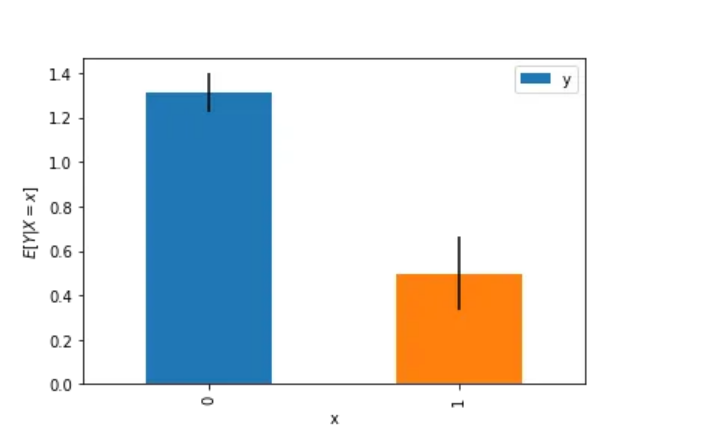

We find the (naive) result that articles perform better than some baseline (Y=0) when they use the new optimizer (X=0), and not as well if they use the old one (X=1). The problem, like in the talk, is that the new optimizer intentionally performs worse than the old one! The authors who are more successful at generating clicks (independent of the optimizer) are the same ones who tend to use the headline optimizer (possibly because Z = they care more about getting clicks!). We expected the opposite outcome than what the naive plot above shows, and we should control (at least) for author. Doing this, we get the next plot:

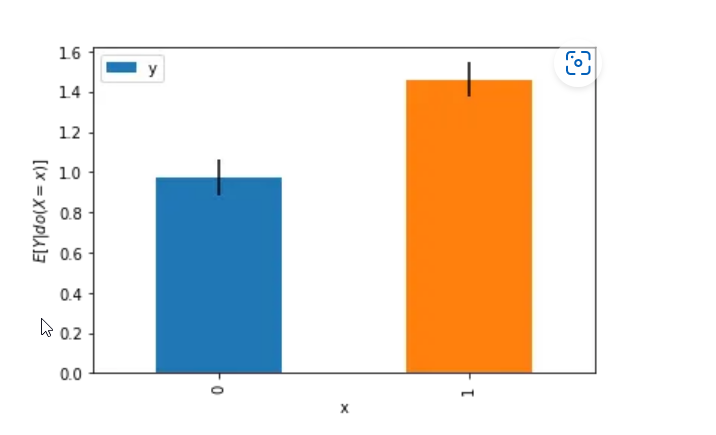

where the performances have flipped! Here, the true values are Y=1 for X=0, and Y=2 for X=1. The X=1 result is outside the confidence interval from the true result, so I might need to do some more exploring on how to bootstrap more conservative confidence intervals. The code is here so you can explore for yourself.

In [11]:
%matplotlib inline

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp
from causality.analysis.dataframe import CausalDataFrame

In [13]:
N = 1000

z = np.random.normal(1., size=N)
x = np.random.binomial(1, p=1./(1. + np.exp(z/.1)))
y = x + z + np.random.normal(size=N)

# It's easy to create a data frame
df = CausalDataFrame({'x': x, 'y': y, 'z': z})

# and the interface to zplot is basically the same as the pandas.DataFrame.plot method!
df.zplot(x='x', y='y', z={'z': 'c'}, kind='mean', bootstrap_samples=1000); pp.y

TypeError: ignored

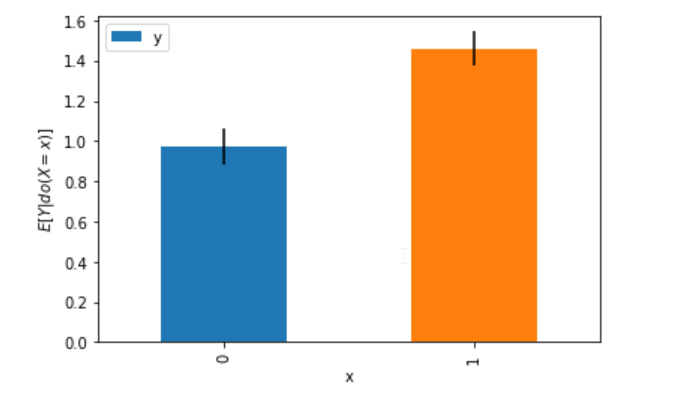

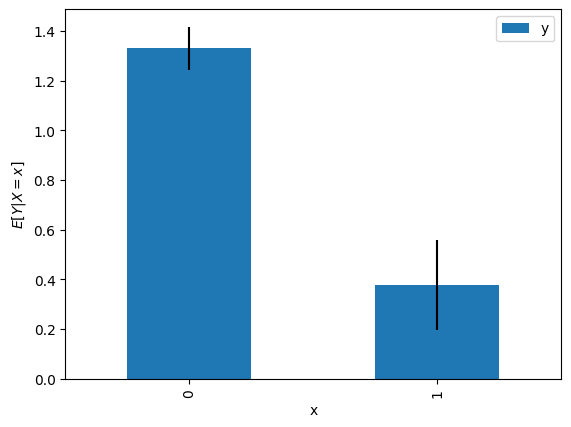

In [14]:
df.groupby('x').mean().plot(y='y', 
                            kind='bar', 
                            yerr=1.96*df.groupby('x').std() / np.sqrt(df.groupby('x').count())); 
pp.ylabel("$E[Y|X=x]$"); pp.show()

Notice we can hack the plot method a little, as usual with pandas, by including matplotlib calls alongside the call to zplot.

This example also included a new kind of plot, 'mean', that’s analogous to using df.groupby('x').mean().plot(y='y', kind='bar'). This is where it becomes apparent the new feature is really a hack — ideally, I’d make the change on the aggregation function, something like DataFrameGroupBy.zmean(), but I’d have to extend the groupby method to return a new, extended DataFrameGroupBy object. I’ll probably do that eventually, but wanted to get this version out there for now.

How it works

The package works by using machine learning estimators to implement Robins’ g-formula. It defaults to a RandomForestRegressor from sklearn, but also natively supports a KernelRegression from statsmodels (which performs better in some test cases). The basic idea is that if a set of variables Z satisfies the back-door criterion for the effect of X on Y, you can use the formula



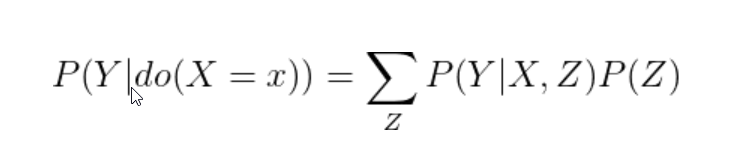

to find the effect of X on Y. This “effect” is the distribution Y will take on if you intervene to set the value of X to x, or “do” the operation X=x. I go into a lot of detail on the formula here in another post.

The idea in this package is that we often just want conditional expectations, so we can take expectation values on both sides of the equation with respect to Y (multiply by Y, and sum over it on both sides) to get the formula

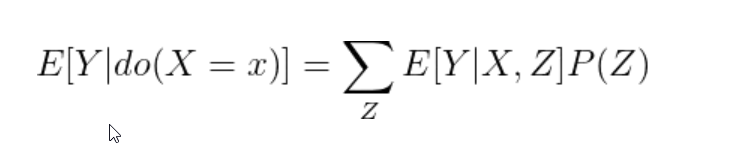

If you minimize mean-squared error with a machine learning estimator that has enough capacity, you get the first factor in the sum, the conditional expectation E[Y|X, Z]. That lets us leverage the power of modern machine learning to do causal inference! We just need a nice way to implement the summation over P(Z), preferably without calculating P(Z). A nice way to do that is to just sum over data points. It’s like a sampling approach for estimating the expectation over Z of the conditional expectation. That gives us the formula,

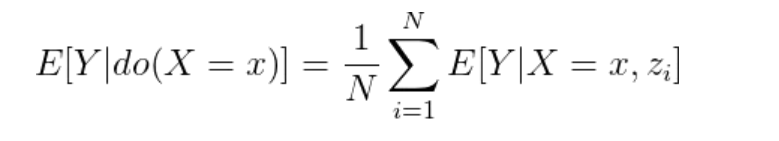

where the index i runs over all of our data points. That’s how the package works! We choose a point x to evaluate the interventional expectation, plug it into each point in the data set, and average the output of the machine learning estimator after evaluating it over each of these points.

I’ve added this g-formula trick to the plotting portion of the library now, and you can check it out one master. Next thing is to add it to the estimators, possibly by extending the DataFrameGroupby object with new methods. This will bring the estimator portion of the package from the traditional binary-valued causal states to arbitrary causal states!

To move from being an experimental implementation, I still need to investigate how accurate the bootstrapped confidence intervals are, the performance on lots of covariates, the tolerance to mixed data types, and more. I’d also like to make it more of a natural extension of the DataFrame by respecting the programming conventions of the pandas package, and, of course, add test coverage. After that, I’ll cut a release. Of course, contributions are welcome!!!